# Pre-Procesamiento

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd
import torch
import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

from sklearn.model_selection import train_test_split

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Fijamos la semilla:

In [40]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [41]:
set_seed(42)

Parametros de la notebook:

In [6]:
DATASET_PATH = '../datasets'

!mkdir -p {DATASET_PATH}

In [7]:
# Se excluyen categorias con menos de 5 productos.
MIN_PRODUCT_BY_CATEGORY = 5

# Se excluyen prodcutos con un title de mas de 150 caracteres.
MAX_PRODUCT_TITLE_SIZE  = 150

### Funciones helper

In [8]:
def plot_categories(groups):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=groups['category'], y='title', data=groups)
    ax.set(xlabel=None)
    ax.set(xticklabels=[])
    plt.show()
    
def plot_title_size(df):
    plt.figure(figsize=(15,10))
    ax = sns.barplot(x='title_size', y='title', data=df)
    ax.set(ylabel=None)
    ax.set(yticklabels=[])
    plt.show()

## Procedimiento

**Step 1**: Cargamos el dataset.

In [9]:
raw_dataset = pd.read_csv(f'{DATASET_PATH}/ebay-dataset.csv')

**Step 2**: Renombramos las columnas a title y category.

In [10]:
raw_dataset = raw_dataset[['name', 'breadcrumbs']]
raw_dataset = raw_dataset.rename(columns={'name':'title', 'breadcrumbs': 'category'})

In [11]:
raw_dataset.shape

(3003, 2)

**Step 3**: Nos quedamos con las categorias que tienen como mínimo MIN_PRODUCT_BY_CATEGORY.

In [12]:
groups = ut.group_by_count(raw_dataset, ['category'], 'title')
groups = groups[groups['title'] >= MIN_PRODUCT_BY_CATEGORY ]
groups.tail()

,category,title
692,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,5
817,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
773,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
820,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
631,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,5


In [13]:
groups.shape

(122, 2)

In [14]:
filtered_dataset = raw_dataset[raw_dataset['category'].isin(groups['category'])]
filtered_dataset.head()

,title,category
1,MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 0...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...
2,Windscreen Kappa Transparent 58x45cm for April...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
4,Honda RS 250 R 1991-1994 DP Brakes Street Sint...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
5,JMT X-ring 530x2 Gold 104 Open Chain With Rive...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
7,1x Summer Tyre Michelin Pilot Sport 4 255/40zr...,eBay ~ Vehicle Parts & Accessories ~ Car Wheel...


In [15]:
raw_dataset.shape, filtered_dataset.shape

((3003, 2), (1934, 2))

**Step 4**: Seleccionamos los productos con descripciones menores a MAX_PRODUCT_TITLE_SIZE caracteres.

<Figure size 1080x720 with 1 Axes>

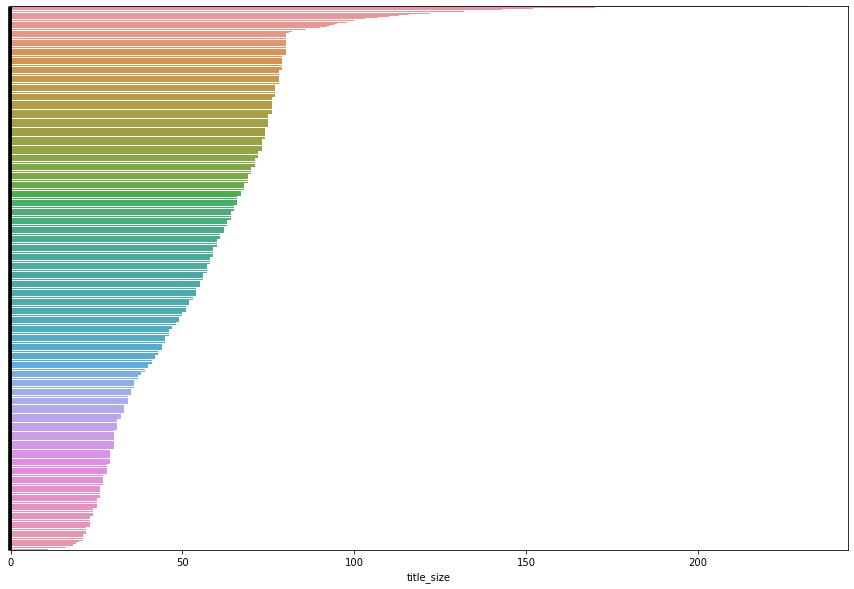

In [16]:
filtered_dataset['title_size'] = filtered_dataset['title'].apply(len)
filtered_dataset = filtered_dataset.sort_values(['title_size'], ascending=False)

plot_title_size(filtered_dataset)

<Figure size 1080x720 with 1 Axes>

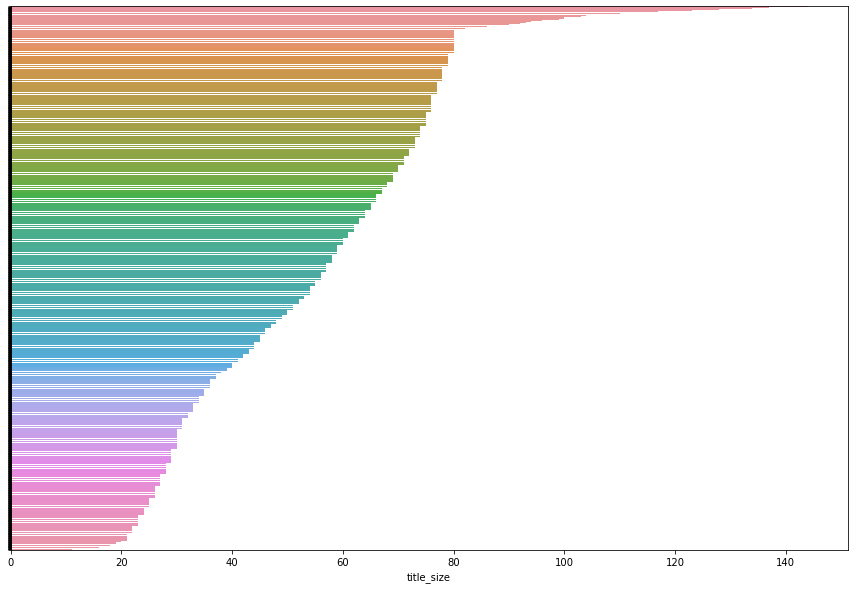

In [17]:
filtered_dataset = filtered_dataset[filtered_dataset['title_size'] < MAX_PRODUCT_TITLE_SIZE]

plot_title_size(filtered_dataset)

In [18]:
filtered_dataset['title_size'].min(), filtered_dataset['title_size'].max()

(11, 144)

In [24]:
filtered_dataset = filtered_dataset.drop(columns=['title_size'])
filtered_dataset.head()

,title,category
1301,Mrs Sinclair's Suitcase: 'A heart-breaking tal...,"eBay ~ Books, Comics & Magazines ~ Books"
2430,Stone Mothers: The addictive new thriller from...,"eBay ~ Books, Comics & Magazines ~ Books"
2423,Don't Close Your Eyes: The astonishing psychol...,"eBay ~ Books, Comics & Magazines ~ Books"
2293,Regency Scandal: Dissolute Ways: The Runaway C...,"eBay ~ Books, Comics & Magazines ~ Books"
593,Gone Without A Trace: a gripping psychological...,"eBay ~ Books, Comics & Magazines ~ Books"


**Step 5**: Agregamos un número de secuencia que representa univocamente a cada categoria.

In [25]:
filtered_dataset = dt.Sequencer('category', 'category_seq').perform(filtered_dataset)
filtered_dataset.head()

,title,category,category_seq
0,Mrs Sinclair's Suitcase: 'A heart-breaking tal...,"eBay ~ Books, Comics & Magazines ~ Books",0
1,Stone Mothers: The addictive new thriller from...,"eBay ~ Books, Comics & Magazines ~ Books",0
2,Don't Close Your Eyes: The astonishing psychol...,"eBay ~ Books, Comics & Magazines ~ Books",0
3,Regency Scandal: Dissolute Ways: The Runaway C...,"eBay ~ Books, Comics & Magazines ~ Books",0
4,Gone Without A Trace: a gripping psychological...,"eBay ~ Books, Comics & Magazines ~ Books",0


In [26]:
filtered_dataset['category_seq'].min(), filtered_dataset['category_seq'].max()

(0, 121)

**Step 6**: Partimos el dataset en los conjuntos de entrenamiento, prueba y validación. Ademas se estratifica para minimasr el efecto del desbalanceo de prodxcutos por categoria.

In [27]:
train_set, test_set, _, _= train_test_split(
    filtered_dataset,
    filtered_dataset['category'].values,
    test_size     = 0.1,
    stratify      = filtered_dataset['category'].values,
    shuffle       = True
)

In [28]:
test_set, val_set, _, _= train_test_split(
    test_set,
    test_set['category'].values,
    test_size     = 0.5,
    shuffle       = False
)

**Step 7**: Chequeamos que en test y evaliacion existan las misma categorias que existe en train.

<Figure size 720x360 with 1 Axes>

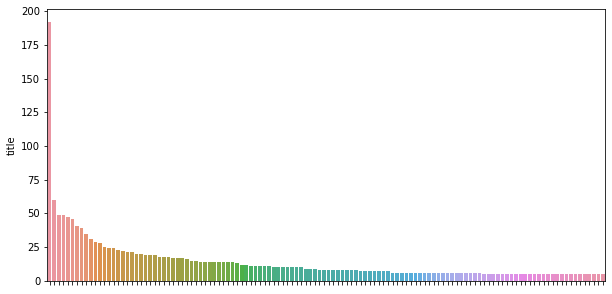

In [29]:
plot_categories(ut.group_by_count(train_set, ['category'], 'title'))

<Figure size 720x360 with 1 Axes>

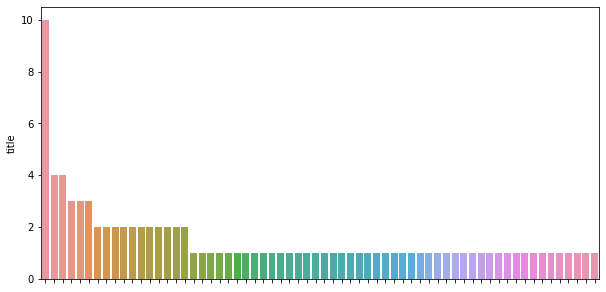

In [30]:
plot_categories(ut.group_by_count(test_set, ['category'], 'title'))

<Figure size 720x360 with 1 Axes>

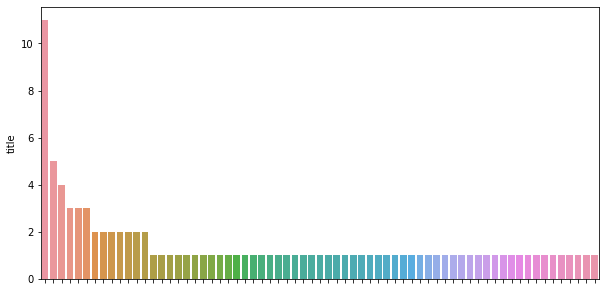

In [31]:
plot_categories(ut.group_by_count(val_set, ['category'], 'title'))

In [32]:
train_set.shape, val_set.shape, test_set.shape

((1731, 3), (97, 3), (96, 3))

Los sets de validación y test deberian tener solo categorias que existan en el set de entrenamiento, de lo contrario, no es posible hacer la predicción:

In [36]:
val_set[val_set['category'].isin(train_set['category'].values)].shape

(97, 3)

In [37]:
test_set[test_set['category'].isin(train_set['category'].values)].shape

(96, 3)

**Step 8**: Guardamos todos los conjuntos preprocesados.

In [39]:
train_set       .to_csv(f'{DATASET_PATH}/ebay-train.csv', index=False)
val_set         .to_csv(f'{DATASET_PATH}/ebay-val.csv',   index=False)
test_set        .to_csv(f'{DATASET_PATH}/ebay-test.csv',  index=False)
filtered_dataset.to_csv(f'{DATASET_PATH}/ebay-all.csv',   index=False)